In [1]:
import numpy as np
import os
import glob
import PIL.Image

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import Callback

import pandas as pd
from pretty_confusion_matrix import pp_matrix

In [2]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])

DATASET_PATH = "./dataset_rot/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
if not os.path.isdir(DATASET_PATH):
    !wget https://fainsil.users.inpt.fr/content/dataset_rot.zip
    !unzip -qq dataset_rot.zip
    !rm dataset_rot.zip

CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)

VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

BATCH_SIZE = 32
EPOCHS = 50

RANDOM_SEED = 2


--2022-05-05 21:51:45--  https://fainsil.users.inpt.fr/content/dataset_rot.zip
Résolution de fainsil.users.inpt.fr (fainsil.users.inpt.fr)… 147.127.160.150
Connexion à fainsil.users.inpt.fr (fainsil.users.inpt.fr)|147.127.160.150|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 71710588 (68M) [application/zip]
Enregistre : «dataset_rot.zip»

dataset_rot.zip     100%[===================>]  68,39M  63,6MB/s    ds 1,1s    

2022-05-05 21:51:46 (63,6 MB/s) - «dataset_rot.zip» enregistré [71710588/71710588]

/tmp/deepl/dataset_rot
['octane', 'werewolf', 'breakout', 'aftershock']


In [3]:
def load_data():
    # Récupération des fichiers
    files = glob.glob(f"{DATASET_PATH}/**/*.jpg", recursive=True)

    # Initialise les structures de données
    x = np.zeros((len(files), *RESIZED_SIZE_PIL))
    y = np.zeros((len(files), 1))

    # print(f"x.shape = {x.shape}")

    for i, path in enumerate(files):
        # Lecture de l'image
        img = PIL.Image.open(path)

        # print(f"img.size = {img.size}")

        # Redimensionnement de l'image
        img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)

        # print(f"img.size = {img.size}")

        test = np.asarray(img)

        # print(f"test.shape = {test.shape}")

        # Remplissage de la variable x
        x[i] = test

        # On récupère l'index dans le path
        class_label = path.split("/")[-2]

        # On récupère le numéro de la classe à partir du string
        class_label = CLASSES.index(class_label)

        # Remplissage de la variable y
        y[i] = class_label

    return x, y


In [4]:
x, y = load_data()
x = x / 255

# shuffle dataset
size = len(y)
indices = np.arange(size)
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# split dataset
test_size = int(TEST_SPLIT * size)
x_test = x[:test_size]
y_test = y[:test_size]

validation_size = int(VALIDATION_SPLIT * size)
x_validation = x[test_size:test_size+validation_size]
y_validation = y[test_size:test_size+validation_size]

x_train = x[test_size+validation_size:]
y_train = y[test_size+validation_size:]


/tmp/ipykernel_1169218/2192415425.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)


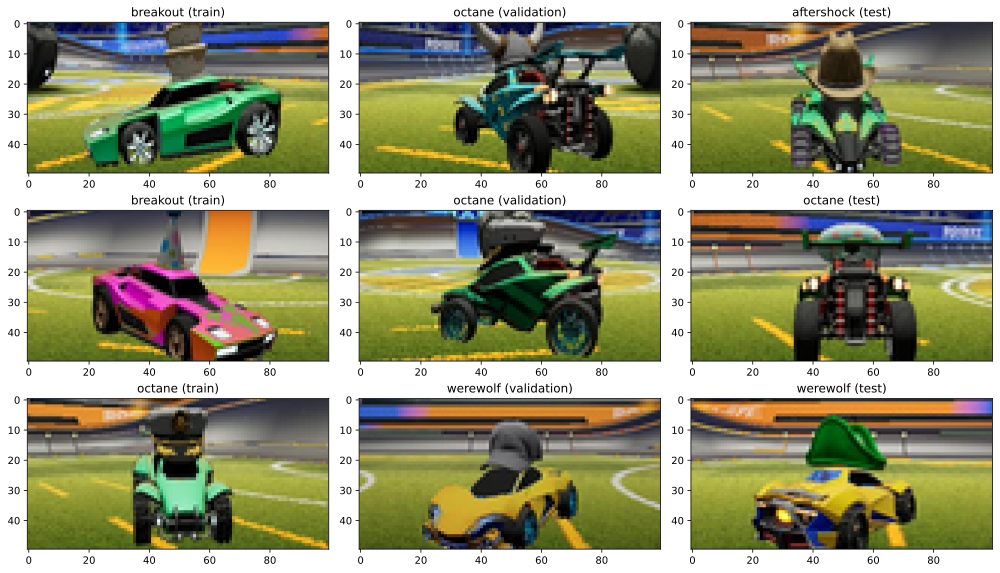

In [5]:
plt.figure(figsize=(14, 8))

for i in range(3):
    # train image
    plt.subplot(3, 3, 3*i + 1)
    plt.title(CLASSES[int(y_train[i])] + " (train)")
    plt.imshow(x_train[i])
    
    # validation image
    plt.subplot(3, 3, 3*i + 2)
    plt.title(CLASSES[int(y_validation[i])] + " (validation)")
    plt.imshow(x_validation[i])
    
    # test image
    plt.subplot(3, 3, 3*i + 3)
    plt.title(CLASSES[int(y_test[i])] + " (test)")
    plt.imshow(x_test[i])

plt.tight_layout()
plt.show()


In [6]:
REGULARIZATION_RATE = 0.0005

# build the model
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE_PIL),
        Conv2D(32, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(92, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE), name="C2D_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(250, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        Dense(4, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 23, 64)       0         
 2D)                                                             
                                                                 
 C2D_last (Conv2D)           (None, 9, 21, 92)         53084     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 10, 92)        0

2022-05-04 18:50:15.947149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 18:50:16.557197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1538 MB memory:  -> device: 0, name: Quadro K620, pci bus id: 0000:03:00.0, compute capability: 5.0


In [7]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))


In [8]:
# train the model on the dataset
history = LossHistory()
adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[history])


Epoch 1/50


2022-05-04 18:50:18.202650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-04 18:50:18.485447: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


88/88 [==============================] - 7s 55ms/step - loss: 11.5202 - accuracy: 0.3686 - val_loss: 11.3857 - val_accuracy: 0.4850
Epoch 2/50
88/88 [==============================] - 4s 46ms/step - loss: 11.2567 - accuracy: 0.5375 - val_loss: 11.1284 - val_accuracy: 0.4967
Epoch 3/50
88/88 [==============================] - 4s 45ms/step - loss: 11.0005 - accuracy: 0.6129 - val_loss: 10.8759 - val_accuracy: 0.7317
Epoch 4/50
88/88 [==============================] - 4s 45ms/step - loss: 10.7490 - accuracy: 0.6914 - val_loss: 10.6255 - val_accuracy: 0.6033
Epoch 5/50
88/88 [==============================] - 4s 46ms/step - loss: 10.4972 - accuracy: 0.6489 - val_loss: 10.3748 - val_accuracy: 0.7067
Epoch 6/50
88/88 [==============================] - 4s 46ms/step - loss: 10.2448 - accuracy: 0.7043 - val_loss: 10.1258 - val_accuracy: 0.6917
Epoch 7/50
88/88 [==============================] - 4s 46ms/step - loss: 9.9922 - accuracy: 0.7568 - val_loss: 9.8757 - val_accuracy: 0.6850
Epoch 8/50
8

In [9]:
# Save the weights
model.save(f"models/rot_{EPOCHS}e")


2022-05-04 18:53:41.554390: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/rot_50e/assets


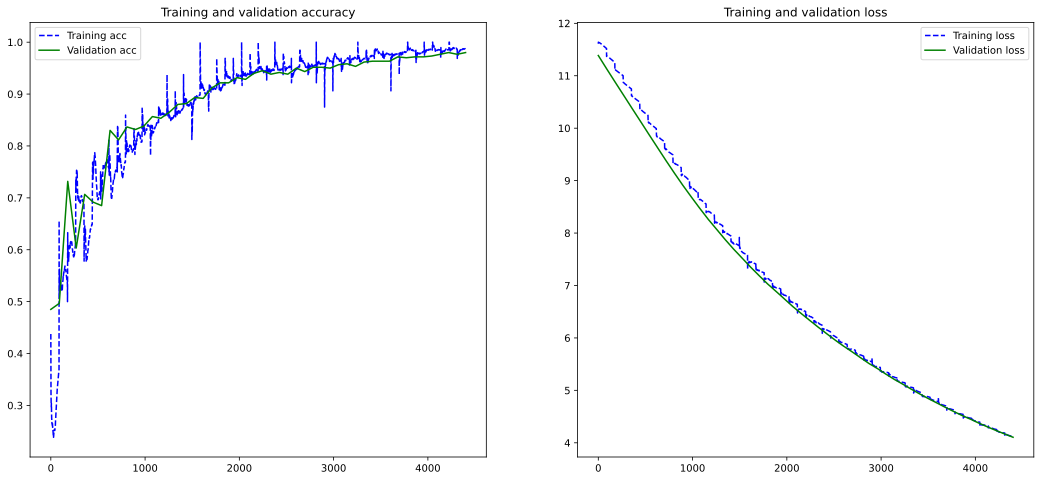

In [10]:
def plot_training_analysis():
    acc = history.accs
    val_acc = history.val_accs
    loss = history.losses
    val_loss = history.val_losses

    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, "b", linestyle="--", label="Training acc")
    plt.plot(np.linspace(0, len(acc), len(val_acc)), val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, "b", linestyle="--", label="Training loss")
    plt.plot(np.linspace(0, len(loss), len(val_loss)), val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


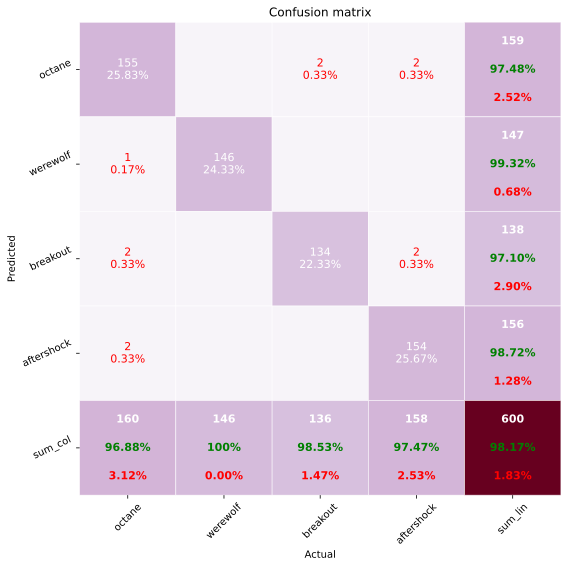

In [11]:
# création des prédictions sur les données de test
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
res = tf.math.confusion_matrix(y_test, prediction)

# get pandas dataframe
df_cm = pd.DataFrame(res, CLASSES, CLASSES)

# pretty_confusion_matrix
pp_matrix(df_cm, cmap="PuRd")

In [12]:
def make_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [13]:
def make_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.004):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img


In [14]:
last_conv_layer_name = "C2D_last"
plt.figure(figsize=(15, 18))

for i in range(10):

    img = x_test[i]

    X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
    X[0] = np.asarray(img)

    # Print what the top predicted class is
    preds = model.predict(X)
    index = np.argmax(preds)

    plt.subplot(10, 5, 5*i+1)
    plt.imshow(img)
    plt.title(f"prediction: {CLASSES[index]}")

    for j in range(4):
        # generate class activation heatmap
        heatmap = make_heatmap(X, model, last_conv_layer_name, pred_index=j)
        # generate gradmap
        gradcam = make_gradcam(img, heatmap)
        
        plt.subplot(10, 5, 5*i+j+2)
        plt.imshow(gradcam)
        plt.title(f"{CLASSES[j]} heatmap")

plt.tight_layout()
plt.show()
